#  Projet Machine Learning

### ALAOUI Emma - LIN Cécile

Github : https://github.com/lincecile/Projet_Machine_Learning


**Insérer une table des matières**

## 1) Sujet

Challenge Data de l'ENS : [Prévision en temps réel du temps d'attente à quai](https://challengedata.ens.fr/participants/challenges/166/)

### 1.1) Contexte

Transilien SNCF Voyageurs est l’opérateur des trains de banlieue en Île-de-France. Nous faisons circuler plus de 6 200 trains permettant à 3,4 millions de voyageurs de se déplacer. Chaque jour, nos trains desservent des milliers d’arrêt, pour faire en sorte que votre voyage se passe au mieux nous donnons un temps d’attente estimé, en minutes à droite sur la Figure 1. Nous souhaitons explorer la possibilité d’améliorer la qualité des prévisions de temps d’attente.

### 1.2) Description des données

**Structure des données**
- Un jeu de données x_train.csv avec 667 265 lignes (i.e. 667 265 arrêts k, s, d) et 10 colonnes
- Un jeu de données x_test.csv avec 20 658 lignes (i.e. 20 658 arrêts k, s, d) et 12 colonnes
- Un jeu de données y_train.csv avec 667 265 lignes et une colonne, donnant la variable à prédire pour le jeu d’entraînement
- Un jeu de données y_sample.csv avec 20 658 lignes et une colonne dont les valeurs sont aléatoires entre [-10, 10]. Il s’agit d’un exemple de soumission que vous pouvez prendre en exemple pour préparer votre soumission

**Origine des données**
Ces données sont issues d’applications métiers permettant d’obtenir les heures théoriques et observées d’arrivées et de départ des trains en gare.
Les données anonymisées sont structurées de la manière suivante, une observation est un arrêt de train (cle_train) à une gare (cle_gare) donnée pour un jour donné (date).

 **La variable p0q0 est la différence entre le temps d’attente théorique et réalisé**. S’il est négatif, cela signifie que le temps d’attente est plus long que prévu sinon cela signifie qu’il est plus court. La différence de temps d’attente est entière car par soucis de simplicité pour nos voyag.eurs.euses nous n’affichons que des minutes sur nos écrans.
Nous vous demandons de prédire la différence de temps d’attente à deux gares en temps réel. Nous introduisons p et q pour définir le passé : p définit les valeurs passées aux arrêts précédents pour le même train, q définit les valeurs passées pour le précédent train à la même gare.

**Variables explicatives**

4 Variables contextuelles :
- train (k) : numéro de train (unique par jour)
- gare (s) : est l’identifiant de la gare
- date (d) : YYYY-MM-DD est la date du jour où le train roule
- arret : numéro de l’arrêt

6 Variables passées :
- p2q0 : différence de temps d’attente du second train précèdent k-2 à la gare s
- p3q0 : différence de temps d’attente du troisième train précèdent k-3 à la gare s
- p4q0 : différence de temps d’attente du quatrième train précèdent k-4 à la gare s
- p0q2 : différence de temps d’attente du même train k à la seconde gare précédente s-2
- p0q3 : différence de temps d’attente du même train k à la troisième gare précédente s-3
- p0q4 : différence de temps d’attente du même train k à la quatrième gare précédente s-4

**Variable cible**

La différence de temps d’attente observé est p0q0 qui est la différence de temps d’attente, noté Y(k,s,d), pour un arrêt, soit un train k à la gare s le jour d.

### 1.3) Description du benchmark

**Benchmark** :
Le modèle de référence utilisé dans ce challenge est un modèle de forêt aléatoire classique.

**Métrique** :
La métrique utilisée est une MAE (Mean Absolute Error) classique.

## 2) Problématique 

Le but de ce challenge pour Transilien SNCF Voyageurs est de vous faire prédire à court-terme le temps d’attente d’un train situé deux gares en amont.
Pour évaluer la performance de votre algorithme, nous vous proposons de prédire la différence entre le temps d’attente théorique et le temps d’attente réalisé à chaque gare sur plusieurs jours Y(k,s,d).

## 3) Préparation des données

### 3.1) Importations des bibliothèques

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Statistiques
from scipy import stats
from scipy.stats import chi2_contingency, kruskal

# Prétraitement
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from xgboost import XGBRegressor

# Évaluation des modèles
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import model_selection

# Interprétabilité
import lime
import shap

# Optimisation
import optuna
from functools import partial 

# Clustering et réduction de dimension
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import sklearn as sk
from IPython.display import HTML
warnings.filterwarnings('ignore')


### 3.2) Importation des données

##### Importation de nos tables en dataframe pandas

In [2]:
x_train = pd.read_csv(r'data/x_train_final.csv')
y_train = pd.read_csv(r'data/y_train_final_j5KGWWK.csv')

x_test = pd.read_csv(r'data/x_test_final.csv')

In [3]:
feature_columns = [
                    # Variables contextuelles
                    'train','gare','date','arret',
                    # Variables passées
                    'p2q0','p3q0','p4q0','p0q2','p0q3','p0q4'
                    ]

base_columns = ['train','gare','arret','p2q0','p3q0','p4q0','p0q2','p0q3','p0q4']

x_train = x_train.drop(columns=['Unnamed: 0.1','Unnamed: 0'], axis=1)
y_train = y_train.drop('Unnamed: 0', axis=1)
x_test = x_test.drop('Unnamed: 0', axis=1)

In [4]:
print(x_train.head())
print(x_test.head())
print(y_train.head())

    train gare        date  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4
0  VBXNMF  KYF  2023-04-03      8   0.0   0.0   1.0  -3.0  -1.0  -2.0
1  VBXNMF  JLR  2023-04-03      9   0.0   0.0   0.0   1.0   0.0   1.0
2  VBXNMF  EOH  2023-04-03     10  -1.0   0.0   0.0  -1.0   0.0   0.0
3  VBXNMF  VXY  2023-04-03     11  -1.0  -1.0   0.0   2.0  -2.0   0.0
4  VBXNMF  OCB  2023-04-03     12  -1.0  -1.0  -1.0  -1.0   3.0   2.0
    train gare        date  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4
0  ZPQEKP  VXY  2023-11-13     12   0.0   0.0  -2.0  -4.0  -2.0  -4.0
1  KIQSRA  VXY  2023-11-13     12   0.0   0.0  -1.0   1.0  -1.0   0.0
2  QQJYYT  VXY  2023-11-13     12   0.0   1.0  -1.0   1.0  -1.0   1.0
3  FVKYMZ  VXY  2023-11-13     12   0.0   0.0  -1.0  -1.0   0.0  -1.0
4  GXNZBY  AZA  2023-11-13     12   1.0  -2.0   0.0   0.0   0.0   0.0
   p0q0
0  -1.0
1  -1.0
2  -1.0
3   1.0
4   3.0


##### Vérification des tailles des fichiers

In [4]:
print("\nDimensions des DataFrames :")
print(f"x_train : {x_train.shape} lignes et colonnes")
print(f"y_train : {y_train.shape} lignes et colonnes")
print(f"x_test : {x_test.shape} lignes et colonnes")

assert len(x_train) == len(y_train), "Erreur: x_train et X_train n'ont pas le même nombre de lignes"


Dimensions des DataFrames :
x_train : (667264, 10) lignes et colonnes
y_train : (667264, 1) lignes et colonnes
x_test : (20657, 10) lignes et colonnes


### 3.3) Exploration des données 

#### Informations sur notre dataset + interprétation

INFORMATIONS GÉNÉRALES SUR LE DATASET

Période couverte: du 2023-04-03 à 2023-11-10
Variables contextuelles:
- Nombre de trains uniques: 37544
- Nombre de gares: 84
- Distribution des arrêts: {7: 266, 8: 35571, 9: 35021, 10: 34821, 11: 34265, 12: 34151, 13: 33174, 14: 30435, 15: 31385, 16: 32131, 17: 31283, 18: 30580, 19: 29205, 20: 28093, 21: 26400, 22: 26291, 23: 26121, 24: 23839, 25: 23677, 26: 24313, 27: 20218, 28: 14529, 29: 15773, 30: 16581, 31: 6700, 32: 4133, 33: 3770, 34: 5968, 35: 3746, 36: 122, 37: 821, 38: 3821, 39: 4, 40: 5, 41: 50, 42: 1}
ANALYSE DE LA VARIABLE CIBLE

Statistiques descriptives de la cible:

count    667264.000000
mean         -0.159950
std           1.987872
min        -160.000000
25%          -1.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: p0q0, dtype: float64


Text(0.5, 1.0, "Distribution de la variable cible des différences de temps d'attente")

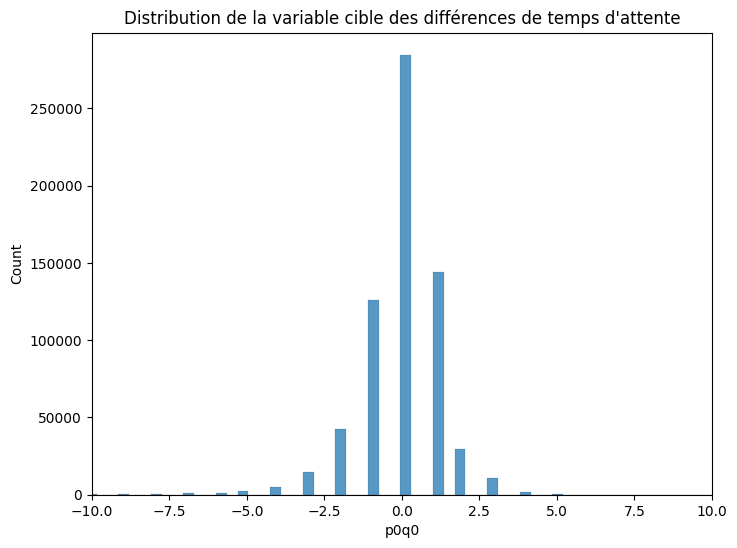

In [4]:
print("INFORMATIONS GÉNÉRALES SUR LE DATASET\n")
print(f"Période couverte: du {x_train['date'].min()} à {x_train['date'].max()}")

print("""Variables contextuelles:\n""" + 
      f"- Nombre de trains uniques: {x_train['train'].nunique()}\n" +
      f"- Nombre de gares: {x_train['gare'].nunique()}\n" +
      f"- Distribution des arrêts: {x_train['arret'].value_counts().sort_index().to_dict()}")

x_train['date'] = pd.to_datetime(x_train['date'])
x_train['jour_semaine'] = x_train['date'].dt.day_name()

print("ANALYSE DE LA VARIABLE CIBLE\n")
print("Statistiques descriptives de la cible:\n")
print(y_train["p0q0"].describe())
plt.figure(figsize=(8,6))

sns.histplot(y_train["p0q0"], bins=500)
plt.xlim(-10, 10)
plt.title("Distribution de la variable cible des différences de temps d'attente")


En observant la variable cible qui est le temps d'attente de notre train cible à la gare cible, on peut remarquer une distribution gaussienne (normale centrée en 0). La distribution est asymétrique, on remarque que les trains sont majoritairement à l'heure (0 minutes de retard). Et on compte plus souvent une légère avance (p0q0 > 0) plutôt qu'un léger retard (p0q0 < 0). 

Attention, on voit cependant que il est plus probable d'avoir un grand retard plutôt qu'une très grande avance.

Variable cible (p0q0):
- Indique la différence entre temps d'attente théorique et réel
- Une valeur négative signifie un temps d'attente plus long que prévu
- Une valeur positive signifie un temps d'attente plus court que prévu

#### Informations sur nos features + interprétation

In [5]:
print("Statistiques descriptives des features numériques:\n")
x_train.drop(columns=['date','arret']).describe()


Statistiques descriptives des features numériques:



,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
count,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000
mean,-0.170696,-0.167304,-0.176308,-0.163223,-0.173579,-0.174436
std,1.976521,1.960416,1.926275,1.988527,2.643148,4.732999
min,-160.000000,-160.000000,-160.000000,-160.000000,-1441.000000,-1441.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000


On retrouve que la médiane de chaque variable est égale à 0, ce qui se rapproche de l'interprétation de la distribution de notre variable cible. On voit que chaque variable, à une distribution similaire, avec un maximum d'avance de 14-15 minutes pour chaque train arrivant à sa gare. 

On remarque un retard similaire pour les gares q0, cependant on voit également des valeurs possiblement abérrantes sur les deux dernières variables explicatives p0q3 et p0q4. Il parait peu probable qu'un train transilien ait 1441 minutes de retard soit 24 heures. Nous étudierons par la suite plus en détail les éventuels outliers.

In [8]:
x_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667264 entries, 0 to 667263
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   train         667264 non-null  object        
 1   gare          667264 non-null  object        
 2   date          667264 non-null  datetime64[ns]
 3   arret         667264 non-null  int64         
 4   p2q0          667264 non-null  float64       
 5   p3q0          667264 non-null  float64       
 6   p4q0          667264 non-null  float64       
 7   p0q2          667264 non-null  float64       
 8   p0q3          667264 non-null  float64       
 9   p0q4          667264 non-null  float64       
 10  jour_semaine  667264 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 56.0+ MB


On voit qu'il n'y a pas de valeurs manquantes, nous n'aurons donc pas besoin de les traiter. Aussi, les variables `train`, `gare` et `date` ne sont pas au format int ou float ce qui signifie que ce sont des variables catégorielles. Il faudra les traiter si l'on veut pouvoir les intégrer au modèle par la suite.

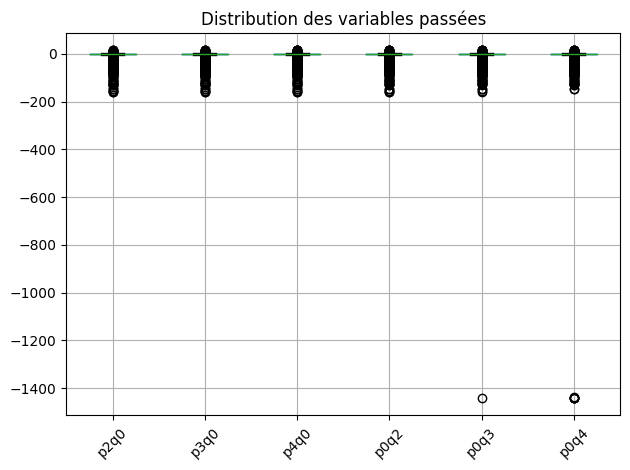

In [6]:
# Boxplot des variables passées
variables_passees = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

x_train[variables_passees].boxplot()
plt.title('Distribution des variables passées')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ce boxplot vient confirmer l'analyse précédente: nos variables ont des outliers.

Ici, la distribution des variables passées


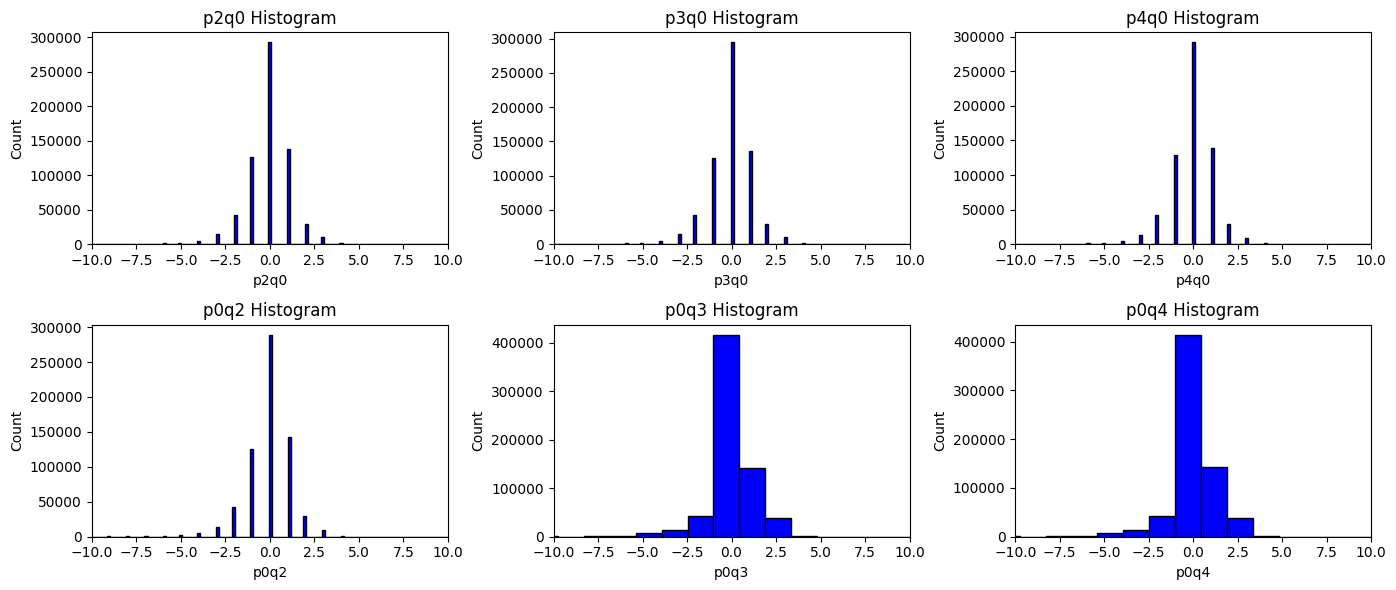

In [ ]:

variable_plot = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

print("Ici, la distribution des variables passées")

plt.figure(figsize=(14, 6)) 

for i, var in enumerate(variable_plot):
    plt.subplot(2, 3, i+1)  
    plt.hist(x_train[var], bins=1000, color='blue', edgecolor='black')  
    plt.xlabel(var)
    plt.xlim(-10, 10)
    plt.ylabel('Count')
    plt.title(f'{var} Histogram')
plt.tight_layout() 
plt.show()




<span style="font-size:40px;">Gestion des outliers.</span>

In [6]:

def outliers(df, colonnes, multiplicateur=3):  
    df_result = df.copy()
    resultats_par_colonne = {}

    for colonne in colonnes:
        Q1 = np.percentile(df_result[colonne], 0.05) 
        Q3 = np.percentile(df_result[colonne], 99) 
        IQR = Q3 - Q1
        limite_inf = Q1 - multiplicateur * IQR
        limite_sup = Q3 + multiplicateur * IQR

        outliers_inf = df_result[colonne] < limite_inf
        outliers_sup = df_result[colonne] > limite_sup

        valeurs_normales = df_result.loc[~(outliers_inf | outliers_sup), colonne]
        remplacement = valeurs_normales.mean()  

        nb_inf = outliers_inf.sum()
        nb_sup = outliers_sup.sum()

        df_result.loc[outliers_inf | outliers_sup, colonne] = remplacement

        resultats_par_colonne[colonne] = f"{nb_inf + nb_sup} valeurs remplacées par la médiane ({remplacement:.2f})"
    print("\nRésumé du traitement des outliers:")
    for col, resultat in resultats_par_colonne.items():
        print(f"- {col}: {resultat}")

    return df_result


In [7]:
continuous_features = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']
x_train = outliers(x_train,continuous_features)
x_test = outliers(x_test,continuous_features)


Résumé du traitement des outliers:
- p2q0: 13 valeurs remplacées par la médiane (-0.17)
- p3q0: 13 valeurs remplacées par la médiane (-0.16)
- p4q0: 15 valeurs remplacées par la médiane (-0.17)
- p0q2: 12 valeurs remplacées par la médiane (-0.16)
- p0q3: 9 valeurs remplacées par la médiane (-0.17)
- p0q4: 13 valeurs remplacées par la médiane (-0.16)

Résumé du traitement des outliers:
- p2q0: 0 valeurs remplacées par la médiane (-0.18)
- p3q0: 0 valeurs remplacées par la médiane (-0.18)
- p4q0: 0 valeurs remplacées par la médiane (-0.09)
- p0q2: 0 valeurs remplacées par la médiane (-0.19)
- p0q3: 0 valeurs remplacées par la médiane (-0.19)
- p0q4: 0 valeurs remplacées par la médiane (-0.19)


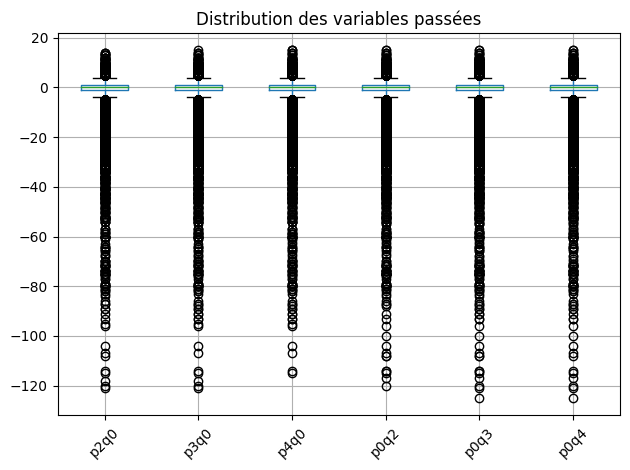

In [9]:
variables_passees = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

x_train[variables_passees].boxplot()
plt.title('Distribution des variables passées')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On a remarqué qu'il y avait des valeurs proches de 120 en valeur absolue, dans la variable cible, c'est pourquoi nous avons supposé que 120 minutes de retard n'était pas une valeur abérrante. Nous avons fait en sorte de supprimer les valeurs telles que 1400 minutes de retard.


<span style="font-size:40px;">Corrélation entre les features et la cible.</span>

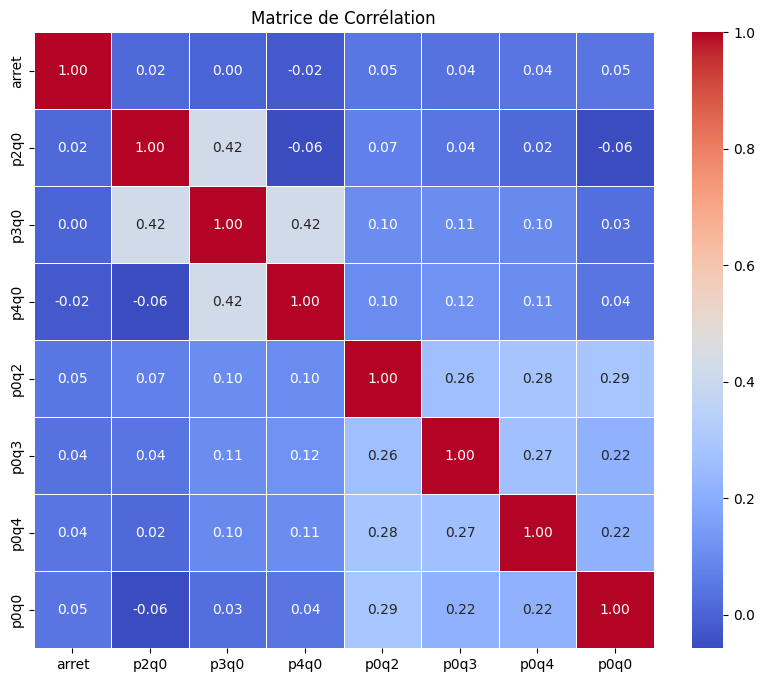

In [14]:
cols_numerical = ['arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']

cible = ['p0q0']
df_correl = pd.concat([x_train, y_train], axis=1)

correlation_matrix = df_correl[cols_numerical+cible].corr() 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

On remarque une corrélation qui se démarque des autres entre les variables p4q0 p3q0 et p3q0 p2q0 (0.42). Cette corrélation semble logique, puisque le retard d'un train précédent affecte le temps de retard du train suivant à une même gare (q0).

On voit également une corrélation entre la variable cible et les variables p0q2 p0q3 p0q4 proche de 30%. Cela fait sens puisqu'il s'agit de notre train cible à des gares précédentes. 

In [15]:
cible = 'p0q0'

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()  
    min_dim = min(confusion_matrix.shape) - 1  
    return np.sqrt(chi2 / (n * min_dim))
cols_numerical.pop(0) 
for col in cols_numerical:
    print(col)
    print(cramers_v(x_train[col], y_train[cible])) 

p2q0
0.0612021773254769
p3q0
0.027154980060137165
p4q0
0.032205699642992705
p0q2
0.22080891942698336
p0q3
0.13552182744974559
p0q4
0.15471784012628914


Comme vu précédemment, on voit que la corrélation entre les variables p0q2 p0q3 p0q4 avec la variable cible p0q0 est plus importante que la corrélation de la cible avec les trains précédents à la gare q0. 

## 4) Traitement et création de nouvelles features

### 4.1) Ajout de nouvelles features et création TRAIN et TEST
On a ajouté des features en utilisant d'autres données, on trouve par exemple:
- Météo (pluviométrie)
- Grèves (mouvements sociaux)
- Malaise voyageur 
- Accidents de personne, accidents du travail 

Par ailleurs on a ajouté les features:
- Jour de la Semaine
- Mois de l'année


In [8]:
x_meteo = pd.read_csv(r'data/open-meteo.csv')

x_accident_voyageur =  pd.read_csv(r'data/incidents-de-securite.csv', sep = ";")
x_accident_voyageur = x_accident_voyageur.groupby(['Date'])[['Gravité EPSF']].sum().reset_index()

x_greve =  pd.read_csv(r'data/mouvements-sociaux.csv', sep = ";")

x_avis =  pd.read_csv(r'data/avis-data.csv', sep = ";")
x_avis = x_avis.groupby('Date')[['Global','Clients','Non-Clients']].mean()

x_accident_travail =  pd.read_csv(r'data/accident-travail-taux.csv', sep = ";")

df_feature_sup = pd.merge(x_meteo,x_greve,how='left',right_on='Date',left_on='time').drop(columns='Date',axis=1)
df_feature_sup = pd.merge(df_feature_sup,x_accident_voyageur,how='left',right_on='Date',left_on='time').drop(columns='Date',axis=1)

df_feature_sup_mensuelle = pd.merge(x_avis,x_accident_travail,how='left',right_on='Date',left_on='Date')

df_feature_sup['Date'] = pd.to_datetime(df_feature_sup['time'], format='%d/%m/%Y').dt.strftime('%Y-%m')
df_feature_sup['time'] = pd.to_datetime(df_feature_sup['time'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
df_feature_final = pd.merge(df_feature_sup,df_feature_sup_mensuelle, how = 'left', on='Date')
df_feature_final['time'] = pd.to_datetime(df_feature_final['time'], format='%Y-%m-%d')
x_test['date'] = pd.to_datetime(x_test['date'], format='%Y-%m-%d')

x_train = pd.merge(x_train,df_feature_final, how='left', right_on='time',left_on='date').reset_index()
x_test = pd.merge(x_test,df_feature_final, how='left', right_on='time',left_on='date').reset_index()

# Création et renommer les variables
x_train['Motif exprimé'].fillna(0,inplace=True)
x_train['mouv_social'] = x_train['Motif exprimé'].apply(lambda x: 1 if x!=0 else x)
x_train['tx grevistes'] = x_train['Taux de grévistes au sein de la population concernée par le préavis'].fillna(0)
x_train.drop(columns=['Motif exprimé','Organisations syndicales','Taux de grévistes au sein de la population concernée par le préavis'], inplace=True)
x_train['Gravité EPSF'].fillna(0,inplace=True)

x_test['Motif exprimé'].fillna(0,inplace=True)
x_test['mouv_social'] = x_test['Motif exprimé'].apply(lambda x: 1 if x!=0 else x)
x_test['tx grevistes'] = x_test['Taux de grévistes au sein de la population concernée par le préavis'].fillna(0)
x_test.drop(columns=['Motif exprimé','Organisations syndicales','Taux de grévistes au sein de la population concernée par le préavis'], inplace=True)
x_test['Gravité EPSF'].fillna(0,inplace=True)

x_train['date'] = pd.to_datetime(x_train['date'])
x_train['jour_semaine'] = x_train['date'].dt.day_name()

### 4.3) Traitement des valeurs manquantes (Imputation)
Pas de valeurs manquantes

In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667264 entries, 0 to 667263
Data columns (total 31 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   index                                      667264 non-null  int64         
 1   train                                      667264 non-null  object        
 2   gare                                       667264 non-null  object        
 3   date                                       667264 non-null  datetime64[ns]
 4   arret                                      667264 non-null  int64         
 5   p2q0                                       667264 non-null  float64       
 6   p3q0                                       667264 non-null  float64       
 7   p4q0                                       667264 non-null  float64       
 8   p0q2                                       667264 non-null  float64       
 9   p0q3

In [11]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20657 entries, 0 to 20656
Data columns (total 30 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   index                                      20657 non-null  int64         
 1   train                                      20657 non-null  object        
 2   gare                                       20657 non-null  object        
 3   date                                       20657 non-null  datetime64[ns]
 4   arret                                      20657 non-null  int64         
 5   p2q0                                       20657 non-null  float64       
 6   p3q0                                       20657 non-null  float64       
 7   p4q0                                       20657 non-null  float64       
 8   p0q2                                       20657 non-null  float64       
 9   p0q3             

### 4.4) Rééquilibrage de la base si besoin

Nous n'avons pas jugé nécessaire de faire un rééquilibrage de la base puisque notre problématique n'est pas de prédire si le train sera oui ou non en retard. Mais plutôt de combien de minutes le temps théorique estimé diffère du temps réel d'arrivée en gare.

## 5) Sélection du modèle

#### Encoding des variables catégorielles

Afin que nos modèles puissent utiliser les variables catégorielles on les encode, ici on utilise un label encoder classique plutôt que d'autres encoder comme le One Hot Encoding, en effet les variables catégorielles que nous avons ont un grand nombre de classes (beaucoup de trains et de gares), on ne peut pas créer une colonne par classe, nous optons donc pour un label encoding.

In [9]:
cols_categorical = ['train','gare']
feature_columns = [
                    # Variables contextuelles
                    'train','gare','date','arret',
                    # Variables passées
                    'p2q0','p3q0','p4q0','p0q2','p0q3','p0q4',
                    # meteo 
                    'precipitation_sum (mm)','temperature_2m_mean (°C)', 'wind_speed_10m_max (km/h)','snowfall_sum (cm)', 'rain_sum (mm)',

                    # mouvements
                    'mouv_social','tx grevistes',

                    # incidents
                    'Gravité EPSF',

                    # avis
                    'Global', 'Clients', 'Non-Clients',

                    # accident travail
                    'Nombre Accidents', "Nombre de jours d'absences", 'Taux de fréquence mensuel','Taux de fréquence annuel glissant 12 mois', 'Taux de gravité mensuel','Taux de gravité annuel glissant 12 mois', 

                    ]

label_encoders = {}

for col in cols_categorical:
    le = LabelEncoder()
    x_train[col] = le.fit_transform(x_train[col]) 
    x_test[col] = le.fit_transform(x_test[col])
    label_encoders[col] = le

def prepare_data(X, columns):
    X = X[columns]
    X['date'] = pd.to_datetime(X['date'])
    X['jour_semaine'] = X['date'].dt.dayofweek
    X['mois'] = X['date'].dt.month
    X = X.drop('date', axis=1)
    return X

x_train = prepare_data(x_train, feature_columns)
x_test = prepare_data(x_test, feature_columns)


In [13]:
print(x_train.head())
print(x_test.head())

   train  gare  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4  \
0  30536    34      8   0.0   0.0   1.0  -3.0  -1.0  -2.0   
1  30536    26      9   0.0   0.0   0.0   1.0   0.0   1.0   
2  30536    14     10  -1.0   0.0   0.0  -1.0   0.0   0.0   
3  30536    68     11  -1.0  -1.0   0.0   2.0  -2.0   0.0   
4  30536    43     12  -1.0  -1.0  -1.0  -1.0   3.0   2.0   

   precipitation_sum (mm)  ...  Clients  Non-Clients  Nombre Accidents  \
0                     0.0  ...     57.0         45.5             222.0   
1                     0.0  ...     57.0         45.5             222.0   
2                     0.0  ...     57.0         45.5             222.0   
3                     0.0  ...     57.0         45.5             222.0   
4                     0.0  ...     57.0         45.5             222.0   

   Nombre de jours d'absences  Taux de fréquence mensuel  \
0                     17573.0                  12.354592   
1                     17573.0                  12.354592   
2       

#### Split

In [10]:
# Fractionner les données (80% train, 20% test par défaut)
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Afficher les dimensions pour vérification
print(f"x_train_split: {x_train_split.shape}, x_test_split: {x_test_split.shape}")
print(f"y_train_split: {y_train_split.shape}, y_test_split: {y_test_split.shape}")
comparaison = []

x_train_split: (533811, 28), x_test_split: (133453, 28)
y_train_split: (533811, 1), y_test_split: (133453, 1)


Nous allons donc tester plusieurs modèles sur nos données d'entrainement pour trouver celui qui minimisera la MAE de notre prediction. Nous nous concentrerons sur des modèles de regression.

In [21]:
models = {
    'XGBoost' : XGBRegressor(n_jobs=-1),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(n_jobs=-1),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'K-Neighbors Regression': KNeighborsRegressor(n_jobs=-1)}

res = list()
for mod in models.values() :
    print(f"Model: {mod.__class__.__name__}")
    # Initialiser le modèle
    model = mod
    # Entraîner le modèle de base
    model.fit(x_train_split, y_train_split)
    # Évaluation du modèle
    y_pred = model.predict(x_test_split)
    mae = mean_absolute_error(y_test_split, y_pred)
    r2 = r2_score(y_test_split, y_pred)    
    # Validation croisée (5-fold)
    cv_scores = sk.model_selection.cross_val_score(model, x_train_split, y_train_split, cv=5, scoring='neg_mean_absolute_error')
    res.append([mod.__class__.__name__,mae,r2,cv_scores])

Model: XGBRegressor
Model: LinearRegression
Model: Ridge
Model: Lasso
Model: ElasticNet
Model: DecisionTreeRegressor
Model: RandomForestRegressor
Model: GradientBoostingRegressor
Model: KNeighborsRegressor


In [22]:
res = pd.DataFrame(res,columns=["model","mae","r2","cv_score"]).sort_values(by="mae",ascending=True) # plus c'est petit mieux c'est
res["cv_mean"] = res['cv_score'].apply(lambda x : np.mean(x))
res.head(5)

,model,mae,r2,cv_score,cv_mean
0,XGBRegressor,0.749357,0.228459,"[-0.7630443208739387, -0.7573247061822632, -0....",-0.756900
6,RandomForestRegressor,0.781394,0.184721,"[-0.7974635407397693, -0.7984804518461623, -0....",-0.794288
7,GradientBoostingRegressor,0.822393,0.169719,"[-0.8341344185909481, -0.8298761939773502, -0....",-0.828921
1,LinearRegression,0.865936,0.130339,"[-0.8801438725509956, -0.8728429979464746, -0....",-0.872966
2,Ridge,0.865936,0.130339,"[-0.8801438672145872, -0.8728429886133111, -0....",-0.872966


Nous constatons que le modèle XGBoost prédit des valeurs avec la MAE la plus faible donc nous allons choisir ce type modèle pour nos predictions. Mais avant de passer à la prédiction, nous allons optimiser les hyperparamètres de ce modèle.

##### **Optimisation des hyperparamètres**

Afin de réduire le temps d'optimisation des hyperparamètres, nous avons choisi de substituer gridsearch par optuna qui propose une optimisation des hyper paramètres basée sur une approche probabiliste.

In [ ]:
# Fonction d'optimisation avec datasets en argument
def objective(trial, X, Y):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50, 100, 200]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0, step=0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0, step=0.2),
    }

    model = XGBRegressor(**params)
    score = cross_val_score(model, X, Y, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
    
    return -score.mean()  # On MINIMISE la MAE

# Fonction pour lancer Optuna
def optimize_hyperparameters(X, Y, n_trials=50):
    study = optuna.create_study(direction="minimize")  # Minimiser la MAE
    study.optimize(lambda trial: objective(trial, X, Y), n_trials=n_trials, n_jobs=-1)

    print("Meilleurs paramètres:", study.best_params)
    print("Meilleur MAE:", study.best_value)
    
    return study.best_params, study.best_value

# Meilleurs hyperparamètres et meilleur modèle
best_params, best_score = optimize_hyperparameters(x_train_split[base_columns], y_train_split, n_trials=30)

print("Meilleurs paramètres:", best_params)
print("Meilleur MAE:", best_score)

# Entraîner le modèle final avec les meilleurs paramètres
best_model = XGBRegressor(**best_params)
best_model.fit(x_train_split[base_columns], y_train_split)


[I 2025-04-08 15:48:40,003] A new study created in memory with name: no-name-a3ab3330-2274-45d9-a79d-2320a40e8455
[I 2025-04-08 15:48:48,183] Trial 1 finished with value: 0.7856551057832108 and parameters: {'n_estimators': 50, 'learning_rate': 0.16000000000000003, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001}. Best is trial 1 with value: 0.7856551057832108.
[I 2025-04-08 15:48:48,812] Trial 0 finished with value: 0.837707550846522 and parameters: {'n_estimators': 100, 'learning_rate': 0.26, 'max_depth': 5, 'subsample': 0.2, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.7856551057832108.
[I 2025-04-08 15:48:54,626] Trial 11 finished with value: 0.8499339973065784 and parameters: {'n_estimators': 50, 'learning_rate': 0.060000000000000005, 'max_depth': 7, 'subsample': 0.2, 'colsample_bytree': 0.2}. Best is trial 1 with value: 0.7856551057832108.
[I 2025-04-08 15:48:59,213] Trial 5 finished with value: 0.8258484017785618 and parameters: {'n_estimators'

Meilleurs paramètres: {'n_estimators': 100, 'learning_rate': 0.21000000000000002, 'max_depth': 9, 'subsample': 1.0, 'colsample_bytree': 0.6000000000000001}
Meilleur MAE: 0.7486754855699086
Meilleurs paramètres: {'n_estimators': 100, 'learning_rate': 0.21000000000000002, 'max_depth': 9, 'subsample': 1.0, 'colsample_bytree': 0.6000000000000001}
Meilleur MAE: 0.7486754855699086


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6000000000000001, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.21000000000000002, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
y_pred_best = best_model.predict(x_test_split[base_columns])
best_mae = mean_absolute_error(y_test_split, y_pred_best)
best_r2 = r2_score(y_test_split, y_pred_best)

print(f"Best Absolute Error: {best_mae}")
print(f"Best R^2 Score: {best_r2}")

best_cv_scores = sk.model_selection.cross_val_score(best_model, x_train_split, y_train_split, cv=5, scoring='neg_mean_absolute_error')
print(f"Best Cross-Validation Scores (neg MAE): {abs(best_cv_scores)}")
print(f"Mean Best Cross-Validation Score (neg MAE): {abs(best_cv_scores.mean())}")

comparaison.append([f"Methode_Standard","XgboostR",best_mae])

Best Absolute Error: 0.7382776982996361
Best R^2 Score: 0.21588663295115018
Best Cross-Validation Scores (neg MAE): [0.75136959 0.74613622 0.74392806 0.74248159 0.74460508]
Mean Best Cross-Validation Score (neg MAE): 0.7457041089211995


Avec notre optimisation d'hyperparamètres nous avons un modèle fine tuné. Nous le retiendrons donc pour la prédiction de la cible. 

Ce modèle nous donne 0.73 de MAE (contre 0.74 de MAE précédemment).

In [12]:
print('Hyperparamètres optimaux :')
best_params

Hyperparamètres optimaux :


{'n_estimators': 100,
 'learning_rate': 0.21000000000000002,
 'max_depth': 9,
 'subsample': 1.0,
 'colsample_bytree': 0.6000000000000001}

## 5) Benchmark

##### **Mesure de performance demandée par le challenge**

- On recréera le benchmark qui est une random forest classique


Nous adaptons également cette metrique pour qu'elle soit utilisable au moment de l'optimisation de nos hyperparamètres.

In [10]:
custom_score = make_scorer(mean_absolute_error, greater_is_better=False)

##### **Création et Entrainement du modèle**

In [11]:
comparaison=[]
result_baseline=[]

# train du modèle
baseline_model = RandomForestRegressor(n_jobs=-1, random_state=42)
baseline_model.fit(x_train_split[base_columns], y_train_split)


RandomForestRegressor(n_jobs=-1, random_state=42)

##### **Prédiction des valeurs**

In [12]:
# Prédictions et évaluation sur les 20% du train set
y_pred_baseline = baseline_model.predict(x_test_split[base_columns])

# Mesure de Performance
mae_bench = mean_absolute_error(y_test_split, y_pred_baseline)
comparaison.append([f"Methode_Standard","benchmark rf",mae_bench])
print(f"Baseline model MAE: {mae_bench}")

Baseline model MAE: 0.7934725334012722


Interprétation: En moyenne le modèle (RF) se trompe de 0.79 minutes (47 secondes)

## 6) Modèle non supervisé

Avec une méthode d'apprentissage non supervisée, on ne peut pas prédire directement le cible puisque cette méthode nous permet de catégoriser nos observations sans pour autant nous donner une réponse précise sur le temps d'avance ou de retard du train cible. Mais on peut envisager de l'utiliser pour explorer ou prétraiter les données avant d'utiliser un modèle supervisé.

Nous utiliserons donc d'abord une Analyse en Composante Principales pour observer nos données, puis utiliserons un Kmeans pour regrouper nos données afin d'améliorer les résultats de nos modèles supervisés. 

### 6.1) ACP

Nous commençons par appliquer une ACP sur nos données pour réduire le nombre de dimensions. Nous affichons la reprensentation de notre nuage de points sur 2 dimensions et la courbe de la variance expliquée en fonction du nombre de dimensions choisi pour notre décomposition.

In [32]:
# normaliser les données

x_train_normalized = x_train.copy(deep=True) 

x_test_normalized = x_test.copy(deep=True)

y_train_normalized = y_train.copy(deep=True)

se_collector = {"train":[],"gare":[],"arret":[],"p2q0":[],"p3q0":[],"p4q0":[],"p0q2":[],"p0q3":[],"p0q4":[],"jour_semaine":[],"mois":[] }

for col in x_train_normalized.columns:
    se = StandardScaler()
    x_train_normalized[col] = se.fit_transform(x_train_normalized[[col]])
    se_collector[col] = se

se_test_collector = {"train":[],"gare":[],"arret":[],"p2q0":[],"p3q0":[],"p4q0":[],"p0q2":[],"p0q3":[],"p0q4":[],"jour_semaine":[],"mois":[]}

for col in x_test_normalized.columns:
    se = StandardScaler()
    x_test_normalized[col] = se.fit_transform(x_test_normalized[[col]])
    se_test_collector[col] = se

se = StandardScaler()
se_y_collector = {'p0q0':[]}

y_train_normalized['p0q0'] = se.fit_transform(y_train_normalized[['p0q0']])
se_y_collector['p0q0'] = se

methods = [("Stardard",x_train_normalized, y_train_normalized, x_test_normalized)]

In [33]:
methods

[('Stardard',
             train      gare     arret      p2q0      p3q0      p4q0      p0q2  \
  0       1.089803 -0.291152 -1.461862  0.089577  0.088559  0.647824 -1.498212   
  1       1.089803 -0.618431 -1.319623  0.089577  0.088559  0.095645  0.612452   
  2       1.089803 -1.109350 -1.177384 -0.443793  0.088559  0.095645 -0.442880   
  3       1.089803  1.099786 -1.035145 -0.443793 -0.449599  0.095645  1.140119   
  4       1.089803  0.077038 -0.892905 -0.443793 -0.449599 -0.456533 -0.442880   
  ...          ...       ...       ...       ...       ...       ...       ...   
  667259 -1.569846 -1.272990  0.529485  0.089577 -0.449599 -3.217425 -0.442880   
  667260 -1.569846 -0.413881  0.671724  0.089577  0.088559 -0.456533  0.612452   
  667261 -1.569846  0.813416  0.813963  0.622948  0.088559  0.095645 -0.442880   
  667262 -1.569846  0.854326  1.098441  1.156319  1.164874  0.647824  0.084786   
  667263 -1.569846  0.240678  1.382919  0.622948  0.626716  1.200002 -2.553545   
  

Variance expliquée : [0.16874343 0.29599968 0.37434567 0.44455729 0.50946593 0.56566972
 0.61269447 0.65511312 0.69332248 0.73119631 0.76697834 0.80269284
 0.83727552 0.868503   0.89668566 0.92318675 0.94876479 0.97330673
 0.98650652 0.99341223 0.99768046 1.         1.         1.
 1.         1.         1.         1.        ]


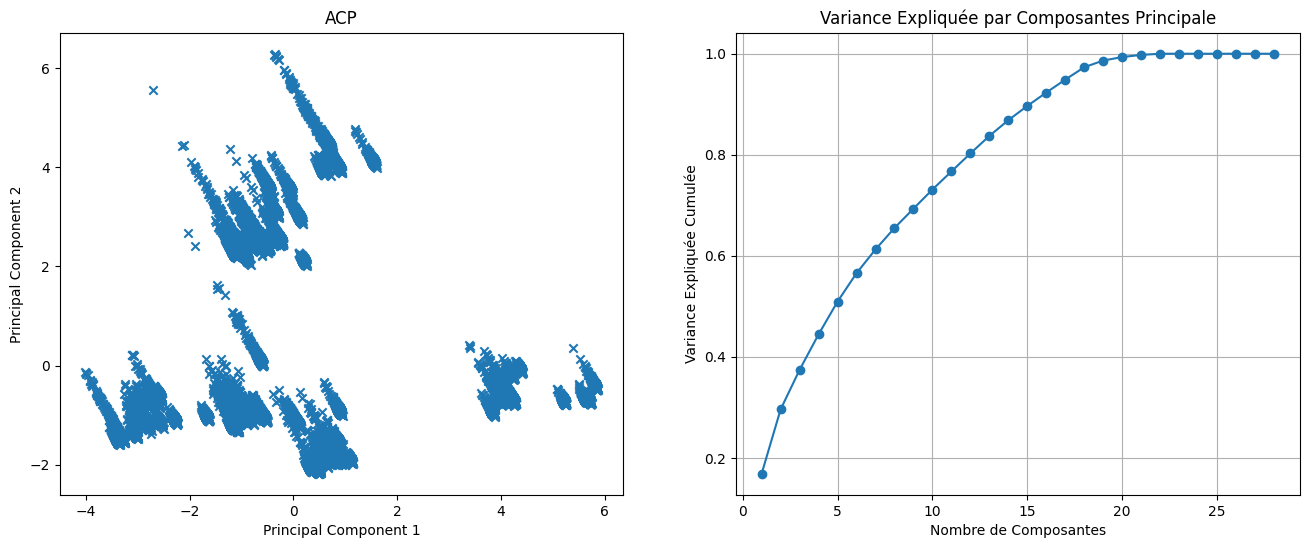

In [ ]:
result_kmeans = []

# PCA pour la réduction de dimensions
pca = PCA() #Pour affichage graphique
x_train_pca = pca.fit_transform(x_train_normalized)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance expliquée : {cumulative_variance}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
# Visualisation des clusters

axes[0].scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1],marker="x")
axes[0].set_title(f"ACP")
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Visualisation de l'évolution de la variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
axes[1].set_xlabel('Nombre de Composantes')
axes[1].set_ylabel('Variance Expliquée Cumulée')
axes[1].set_title(f'Variance Expliquée par Composantes Principale')
axes[1].grid(True)
plt.show()
   

Observations :
* La courbe montre une augmentation logarithmique de la variance expliquée et ce jusqu'à atteindre un plateau à 20 composantes après quoi on a une variance expliquée de 100%. 

* On peut dire que les premières composantes capturent plutôt bien les informations importantes et que plus on ajoute de composantes plus le gain en information devient minime.

* Pour expliquer plus de 95% de la variance, nous devons garder au minimum 15.

### 6.2) Kmeans

#### 6.2.1) Ajout de Features

Nous allons utiliser un kmeans pour regrouper nos données en cluster et leur ajouter des données qui pourraient être utiles dans notre analyse.

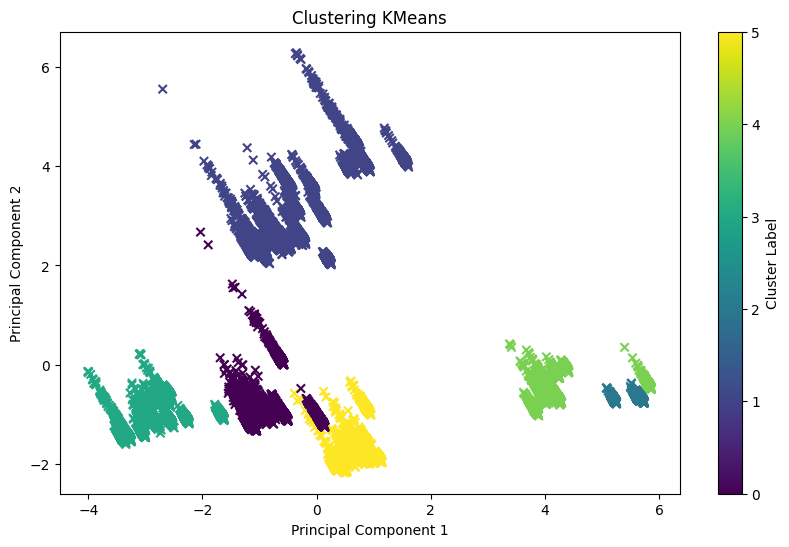

In [ ]:
methods_features=[]
# PCA pour la réduction de dimensions
pca = PCA()
x_train_pca = pca.fit_transform(x_train_normalized)
x_test_pca = pca.transform(x_test_normalized)

# KMeans Clustering

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(x_train_pca)
clusters = kmeans.predict(x_train_pca)
clusters_test = kmeans.predict(x_test_pca)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1], c=clusters, marker= 'x', cmap='viridis')
plt.title(f"Clustering KMeans")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

# ajout des centroids et cluster aux données existantes
x_train_pca = pd.DataFrame(x_train_pca, index=x_train_normalized.index)
x_test_pca = pd.DataFrame(x_test_pca, index=x_test_normalized.index)
clusters = pd.DataFrame(clusters, index=x_train_normalized.index, columns=['cluster'])
clusters_test = pd.DataFrame(clusters_test, index=x_test_normalized.index, columns=['cluster'])

centroids = kmeans.cluster_centers_
for i,c in enumerate(centroids) :
    for j in range(len(c)):
        clusters.loc[clusters.cluster==i,f'cluster_{j}'] = c[j]
        clusters_test.loc[clusters_test.cluster==i,f'cluster_{j}'] = c[j]

data_cluster = pd.concat([x_train_normalized, clusters],axis=1)
data_cluster_test = pd.concat([x_test_normalized, clusters_test],axis=1)
methods_features.append(('Cluster', data_cluster, y_train_normalized, data_cluster_test))

# ajout de la moyenne
data_cluster_1 = x_train_normalized.copy()
data_cluster_1['mean_x_train_cluster'] = data_cluster.groupby('cluster')['cluster_1'].transform('mean')

data_cluster_test_1 = x_test_normalized.copy()
data_cluster_test_1['mean_x_test_cluster'] = data_cluster_test.groupby('cluster')['cluster_1'].transform('mean')

methods_features.append(('Mean',data_cluster_1,y_train_normalized,data_cluster_test_1))


In [36]:
methods = methods + methods_features

In [37]:
methods

[('Stardard',
             train      gare     arret      p2q0      p3q0      p4q0      p0q2  \
  0       1.089803 -0.291152 -1.461862  0.089577  0.088559  0.647824 -1.498212   
  1       1.089803 -0.618431 -1.319623  0.089577  0.088559  0.095645  0.612452   
  2       1.089803 -1.109350 -1.177384 -0.443793  0.088559  0.095645 -0.442880   
  3       1.089803  1.099786 -1.035145 -0.443793 -0.449599  0.095645  1.140119   
  4       1.089803  0.077038 -0.892905 -0.443793 -0.449599 -0.456533 -0.442880   
  ...          ...       ...       ...       ...       ...       ...       ...   
  667259 -1.569846 -1.272990  0.529485  0.089577 -0.449599 -3.217425 -0.442880   
  667260 -1.569846 -0.413881  0.671724  0.089577  0.088559 -0.456533  0.612452   
  667261 -1.569846  0.813416  0.813963  0.622948  0.088559  0.095645 -0.442880   
  667262 -1.569846  0.854326  1.098441  1.156319  1.164874  0.647824  0.084786   
  667263 -1.569846  0.240678  1.382919  0.622948  0.626716  1.200002 -2.553545   
  

##### **Etudes de nouvelles données obtenues via l'ACP**

Pour les deux premières methodes, les nouvelles données sont très peu corrélées avec la variable cible. Mais pour notre méthode 3, les données sont un peu plus corrélées et apportent des informations supplémentaire. Nous les garderons donc pour nos prévisions.

#### 6.2.2) Prediction après clustering

Nous allons utiliser un Kmeans pour faire une prédiction de notre variable cible.

In [ ]:
result_kmeans = []
for i,method in enumerate(methods):
    nom,x_train_kmeans,y_train_kmeans,x_test_kmeans = method

    # PCA pour la réduction de dimensions
    pca = PCA()
    x_train_pca = pca.fit_transform(x_train_kmeans)
    x_train_pca = pd.DataFrame(x_train_pca, index=x_train_kmeans.index)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(x_train_pca)
    x_train_pca['cluster'] = kmeans.predict(x_train_pca)

    # Calcule du y_pred comme la moyenne des clusters pour l'entraînement
    x_train_pca = pd.concat([x_train_pca, y_train_kmeans],axis=1)
    groups = x_train_pca.groupby(by='cluster')
    map_y = {}
    for nb,group in groups:
        map_y[nb] = group["p0q0"].mean()
    x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

    # Calcul de la MAE
    mae = mean_absolute_error(se_y_collector['p0q0'].inverse_transform(y_train_kmeans[['p0q0']]),se_y_collector['p0q0'].inverse_transform(x_train_pca[['y_pred']]))
    # inverse transform pour ne pas avoir une MAE biaisée par la normalisation
    result_kmeans.append([f"Methode_{nom}",20,mae,kmeans,map_y,pca])
    
result_kmeans=pd.DataFrame(result_kmeans,columns=['Methode','nb_composante','MAE','Model','Map','PCA'])

In [39]:
result_kmeans

,Methode,nb_composante,MAE,Model,Map,PCA
0,Methode_Stardard,20,0.959978,"KMeans(n_clusters=3, random_state=42)","{0: 0.008002889451923035, 1: -0.02455886275277...",PCA()
1,Methode_Cluster,20,0.959393,"KMeans(n_clusters=3, random_state=42)","{0: -0.001789375274923155, 1: -0.0245588627527...",PCA()
2,Methode_Mean,20,0.959978,"KMeans(n_clusters=3, random_state=42)","{0: 0.008002889451923035, 1: -0.02455886275277...",PCA()


On a une MAE assez élevée comparé aux modèles précédents, on ne retiendra donc pas ce modèle par la suite.

##### **Optimisation**

On va utiliser le set d'indice 1 mais ils ont tous une MAE similaire.

2
0.265610768110479
4
0.19544321539044682
6
0.22853301671814463
8
0.254197947792175


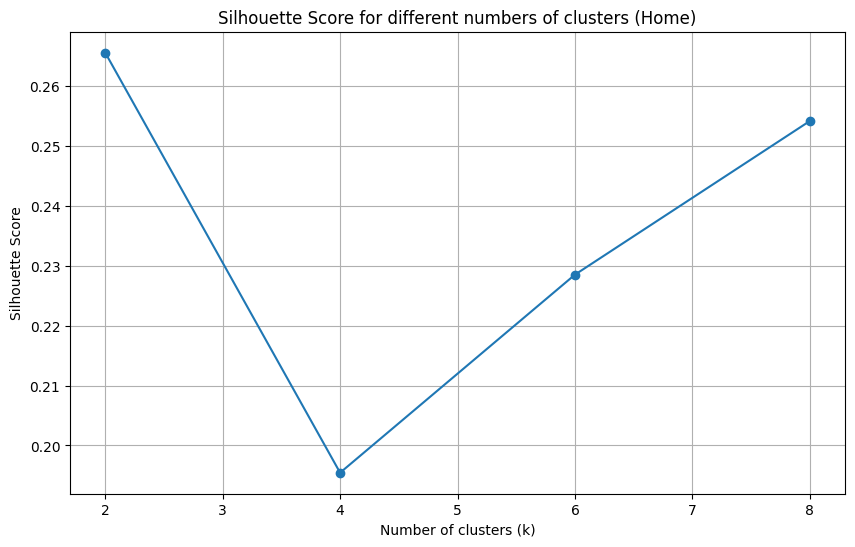

Meilleur nb de cluster : 2  pour un score de  0.265610768110479


In [ ]:
# Fonction pour calculer le score de silhouette pour un nombre de clusters donné
x_train_set = methods[1][1]

def compute_silhouette_score(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    return score

score_sil = []
kmax = 10
for k in range(2, kmax, 2):
    print(k)
    result = compute_silhouette_score(k, x_train_set)
    print(result)
    score_sil.append(result)


# Afficher les scores de silhouette
#k_values, silhouette_scores_home = zip(*[(result[0], result[1]) for result in score_sil])
plt.figure(figsize=(10, 6))
plt.plot([k for k in range(2, kmax,2)],score_sil, marker='o')
plt.title('Silhouette Score for different numbers of clusters (Home)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Extraire les meilleurs résultats
score = max(score_sil)
k_ideal = score_sil.index(score) +2
print(f"Meilleur nb de cluster :",k_ideal," pour un score de ",score)


Le score de silhouette nous donne 2 comme nombre de cluster idéal. Cependant, pour le bien de la prediction, nous allons en prendre plus et vérifier si les performances sont meilleures.

In [ ]:
# PCA pour la réduction de dimensions
pca = PCA()
x_train_pca = pca.fit_transform(x_train_normalized)
x_train_pca = pd.DataFrame(x_train_pca,index=x_train_normalized.index)

# KMeans Clustering
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(x_train_pca)
x_train_pca['cluster'] = kmeans.predict(x_train_pca)

# Calcule de y_pred comme la moyenne des clusters pour l'entraînement
x_train_pca = pd.concat([x_train_pca,y_train_normalized],axis=1)
groups = x_train_pca.groupby(by='cluster')
map_y = {}
for nb,group in groups:
    map_y[nb] = group["p0q0"].mean()
x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

# Calcul de la MAE
mae_pca = mean_absolute_error(se_y_collector['p0q0'].inverse_transform(y_train_normalized[['p0q0']]),se_y_collector['p0q0'].inverse_transform(x_train_pca[['y_pred']]))
comparaison.append([f"Methode_Standard","Kmeans",mae_pca])
mae_pca

0.9588369735381062

Nous obtenons une légère amélioration de performance -par rapport à 6 clusters- en prédiction (0.9588 contre 0.9593), donc nous retenons ce modèle.

##### **Prediction de la *cible***

In [26]:
X_test_Kmeans = x_train_normalized.copy()
X_test_Kmeans = pd.DataFrame(pca.transform(X_test_Kmeans),index=X_test_Kmeans.index)
X_test_Kmeans['cluster'] = kmeans.predict(X_test_Kmeans)
X_test_Kmeans['p0q0'] = X_test_Kmeans['cluster'].apply(lambda x : map_y[x])
y_test_Kmeans = X_test_Kmeans[['p0q0']]
y_test_Kmeans

,p0q0
0,0.033505
1,0.033505
2,0.033505
3,0.033505
4,0.033505
...,...
667259,-0.039542
667260,-0.039542
667261,-0.039542
667262,-0.039542


## 7) Modèle supervisé

### 7.1) Classification

Dans cette partie, nous allons tester plusieurs modèles de classification différents et comparer toujours la Mean Absolute Error afin de trouver le modèle le plus performant.

On peut utiliser des modèles de classification si on part du principe que notre cible est une variable discrète. Puisque les temps sont arrondis à l'entier relatif on peut donc partir du principe que chaque classe correspond à un temps. Par exemple si la cible vaut 1 cela signifie que le temps a été arrondi à 1 minute. De cette manière on a des "classes" et on peut classifier le retard.

##### **Selection des modèles**

In [ ]:
result_supervised = []

In [14]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)
rf_model.fit(x_train_split, y_train_split)
y_pred_rf = rf_model.predict(x_test_split)
mae_rf = mean_absolute_error(y_test_split['p0q0'], y_pred_rf)
result_supervised.append(("RF",mae_rf,rf_model))

In [15]:
# Regression logistique
rl_model = LogisticRegression(multi_class='multinomial',n_jobs=-1,random_state=42)
rl_model.fit(x_train_split, y_train_split)
y_pred_rl = rl_model.predict(x_test_split)
mae_rl = mean_absolute_error(y_test_split['p0q0'], y_pred_rl)
result_supervised.append(("Logistic",mae_rl,rl_model))


In [16]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
knn_model.fit(x_train_split, y_train_split)
y_pred_knn = knn_model.predict(x_test_split)
mae_knn = mean_absolute_error(y_test_split['p0q0'], y_pred_knn)
result_supervised.append(("KNN",mae_knn,knn_model))

result_supervised=pd.DataFrame(result_supervised,columns=["Type","MAE","Modele"])
result_supervised.sort_values('MAE',inplace=True)

In [18]:
result_supervised

,Type,MAE,Modele
0,RF,0.713225,"(DecisionTreeClassifier(max_features='sqrt', r..."
1,Logistic,0.888163,"LogisticRegression(multi_class='multinomial', ..."
2,KNN,1.162372,KNeighborsClassifier(n_jobs=-1)


Avec nos resultats, le modèle de Random Forest parait le plus performant. Nous allons donc retenir ce modèle et faire une optimisation des hyperparamètres afin de trouver les hyperparamètres qui donnent le modèle le plus performant.

##### **Optimisation des hyperparamètres**

In [ ]:

# Fonction d'optimisation avec datasets en argument
def objective(trial, X, Y):
    # Choisir les hyperparamètres à optimiser
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 150])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_depth = trial.suggest_categorical('max_depth', [5, 10, 15])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])
    
    # Créer le modèle avec les hyperparamètres choisis
    model = RandomForestClassifier(n_estimators=n_estimators, 
                                   max_features=max_features,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf)
    
    # Effectuer la validation croisée
    score = cross_val_score(model, X, Y, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
    
    # Retourner la moyenne de la MAE (score négatif car nous voulons minimiser)
    return -score.mean()   # On MINIMISE la MAE

def optimize_hyperparameters(X, Y, n_trials=50):
    study = optuna.create_study(direction="minimize")  # Minimiser la MAE
    study.optimize(lambda trial: objective(trial, X, Y), n_trials=n_trials, n_jobs=-1)

    print("Meilleurs paramètres:", study.best_params)
    print("Meilleur MAE:", study.best_value)
    
    return study.best_params, study.best_value

# Meilleurs hyperparamètres et meilleur modèle
best_params, best_score = optimize_hyperparameters(x_train_split, y_train_split, n_trials=10)

print("Meilleurs paramètres:", best_params)
print("Meilleur MAE:", best_score)

# Entraîner le modèle final avec les meilleurs paramètres
best_model = RandomForestClassifier(**best_params)
best_model.fit(x_train_split, y_train_split)


[I 2025-04-08 15:57:37,695] A new study created in memory with name: no-name-93cf51a1-c74b-498b-8cb2-eb612dfc8d79
[I 2025-04-08 16:00:51,200] Trial 4 finished with value: 0.8312249091907061 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.8312249091907061.
[I 2025-04-08 16:00:55,709] Trial 5 finished with value: 0.8445742032292328 and parameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.8312249091907061.
[I 2025-04-08 16:01:02,028] Trial 1 finished with value: 0.8278697891201192 and parameters: {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8278697891201192.
[I 2025-04-08 16:01:03,309] Trial 0 finished with value: 0.7178083628849912 and parameters: {'n_estimators': 50, 'max_features': 'sqrt', '

Meilleurs paramètres: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}
Meilleur MAE: 0.717735303318965
Meilleurs paramètres: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2}
Meilleur MAE: 0.717735303318965


RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=150)

##### **Prediction sur nos données X_test**

In [22]:
pred = best_model.predict(x_test_split)
mae_rfc = mean_absolute_error(y_test_split['p0q0'], pred)
comparaison.append([f"Methode_rf","RandomForestClassifier",mae_rfc])
mae_rfc

0.7172712490539741

On trouve une MAE de 0.7172, cela indique que le modèle se trompe d'environ 0.71 minutes soit 42 secondes en moyenne.

Nous pourrions avoir de meilleurs résultats après avoir fine tuné les hyper paramètres. Comme cela demanderait de faire tourner le code précédent pendant beaucoup plus de temps, nous avons décidé pour ce notebook de passer à la suite. Et nous avons décidé de fine tuner les hyper paramètres et trouver le meilleur modèle dans un second notebook `model_testing.ipynb` 

### 7.2) Regression

##### **Selection des modèles**

In [34]:
result_supervised = []
    
# LinearRegression
lin_model = LinearRegression(n_jobs=-1)
lin_model.fit(x_train_split, y_train_split)
y_pred_lin = lin_model.predict(x_test_split)
mae_lin = mean_absolute_error(y_test_split, y_pred_lin)
result_supervised.append(("Linear",mae_lin,lin_model))


In [35]:
# Ridge
ridge_model = Ridge(alpha=0.1,random_state=42)
ridge_model.fit(x_train_split, y_train_split)
y_pred_ridge = ridge_model.predict(x_test_split)
mae_ridge = mean_absolute_error(y_test_split, y_pred_ridge)
result_supervised.append(("ridge",mae_ridge,ridge_model))


In [36]:

# RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
rf_model.fit(x_train_split, y_train_split)
y_pred_rf = rf_model.predict(x_test_split)
mae_rf = mean_absolute_error(y_test_split, y_pred_rf)
result_supervised.append(("RF",mae_rf,rf_model))

result_supervised=pd.DataFrame(result_supervised,columns=["Type","MAE","Modele"])
result_supervised.sort_values('MAE',inplace=True)

In [37]:
result_supervised

,Type,MAE,Modele
2,RF,0.781732,"(DecisionTreeRegressor(max_features=1.0, rando..."
0,Linear,0.865936,LinearRegression(n_jobs=-1)
1,ridge,0.865936,"Ridge(alpha=0.1, random_state=42)"


Le random Forest semble être le modèle le plus performant. Nous allons optimiser ses hyper paramètres afin d'obtenir le meilleur modèle possible.

##### **Optimisation des hyperparamètre**

In [38]:
# Fonction d'optimisation avec datasets en argument
def objective(trial, X, Y):
    # Choisir les hyperparamètres à optimiser
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 150])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_depth = trial.suggest_categorical('max_depth', [5, 10, 15])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])
    
    # Créer le modèle avec les hyperparamètres choisis
    model = RandomForestRegressor(n_estimators=n_estimators, 
                                   max_features=max_features,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf)
    
    # Effectuer la validation croisée
    score = cross_val_score(model, X, Y, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
    
    # Retourner la moyenne de la MAE (score négatif car nous voulons minimiser)
    return -score.mean()  # On MINIMISE la MAE

# Meilleurs hyperparamètres et meilleur modèle
best_params, best_score = optimize_hyperparameters(x_train_split, y_train_split, n_trials=10)

print("Meilleurs paramètres:", best_params)
print("Meilleur MAE:", best_score)

# Entraîner le modèle final avec les meilleurs paramètres
best_model = RandomForestRegressor(**best_params)
best_model.fit(x_train_split, y_train_split)


[I 2025-04-02 16:19:42,034] A new study created in memory with name: no-name-258a54c3-afbb-4d4c-9a20-4efcc9550d40
[I 2025-04-02 16:20:48,710] Trial 0 finished with value: 0.7961103805825579 and parameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7961103805825579.
[I 2025-04-02 16:21:41,390] Trial 7 finished with value: 0.818878411441624 and parameters: {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7961103805825579.
[I 2025-04-02 16:22:26,202] Trial 2 finished with value: 0.8523009577909288 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7961103805825579.
[I 2025-04-02 16:22:50,812] Trial 4 finished with value: 0.7960389634445383 and parameters: {'n_estimators': 150, 'max_features': 'log2',

Meilleurs paramètres: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}
Meilleur MAE: 0.7898716654516718
Meilleurs paramètres: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}
Meilleur MAE: 0.7898716654516718


RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150)

##### **Prediction sur nos données X_test**

In [24]:
pred = best_model.predict(x_test_split)
mae_rfr = mean_absolute_error(y_test_split['p0q0'], pred)
comparaison.append([f"Methode_","RandomForestRegressor",mae_rfr])
mae_rfr

0.781494308373933

Comme indiqué précédemment nous laissons ce résultat avec une optimisation des hyper paramètres sur peu d'options. Nous poursuivrons cette recherche de meilleur modèle dans le fichier `model_testing.ipynb`

### 7.3) Modèle d'ensemble

Nous allons également utiliser un modèle "VotingClassifier" qui nous permet de combiner plusieurs modèles d'apprentissage pour obtenir une prédiction. 

**Creation du modèle**

In [ ]:
# Définir les modèles individuels
model1 = LogisticRegression(n_jobs=-1,random_state=42)
model2 = RandomForestClassifier(n_jobs=-1,random_state=42)
model3 = XGBRegressor(n_jobs=-1,random_state=42)


# Créer le VotingClassifier
voting_hard = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('xgb', model3)], voting='hard')
voting_soft = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('xgb', model3)], voting='soft')

**Optimisation des hyperparamètre**

In [ ]:
# Fonction de scoring : utiliser la MAE dans cross_val_score
def mae_scorer(estimator, X, Y):
    y_pred = estimator.predict(X)
    return mean_absolute_error(Y, y_pred)

# Définir l'espace des hyperparamètres à explorer dans Optuna
def objective(trial, X, Y):  # X et Y sont maintenant passés ici
    # Définition des hyperparamètres pour chaque modèle
    lr_C = trial.suggest_categorical('lr_C', [0.1, 1, 10])  # hyperparamètre pour LogisticRegression
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200, step=50)  # hyperparamètre pour RandomForest
    rf_max_depth = trial.suggest_categorical('rf_max_depth', [5, 10, 20])  # hyperparamètre pour RandomForest
    knn_n_neighbors = trial.suggest_int('knn_n_neighbors', 3, 7)  # hyperparamètre pour KNeighborsClassifier
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])  # hyperparamètre pour KNeighborsClassifier

    # Créer un pipeline de modèles avec les hyperparamètres suggérés
    voting_hard = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(C=lr_C,n_jobs=-1)),
            ('rf', RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth,n_jobs=-1)),
            ('knn', KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights,n_jobs=-1))
        ],
        voting='hard'
    )
    
    # Évaluation du modèle avec validation croisée
    scores = cross_val_score(voting_hard, X, Y, cv=5, scoring=mae_scorer,n_jobs=-1)
    
    return scores.mean()  # Retourner la moyenne des scores pour la validation croisée

# Créer l'étude Optuna pour optimiser les hyperparamètres
study_hard = optuna.create_study(direction='minimize')  # On minimise MAE (plus c'est bas, mieux c'est)

# Utilisation de partial pour passer X et Y à la fonction objective
objective_with_data = partial(objective, X=x_train_split.sample(frac=0.1,random_state=1), Y=y_train_split.sample(frac=0.1,random_state=1))

study_hard.optimize(objective_with_data, n_trials=20,n_jobs=-1)

# Afficher les meilleurs hyperparamètres pour l'approche hard
print("Meilleurs hyperparamètres hard:", study_hard.best_params)

# Répéter le processus pour l'approche soft en ajustant 'voting' à 'soft'
def objective_soft(trial, X, Y):
    # Définition des hyperparamètres pour chaque modèle
    lr_C = trial.suggest_categorical('lr_C', [0.1, 1, 10])  # hyperparamètre pour LogisticRegression
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200, step=50)  # hyperparamètre pour RandomForest
    rf_max_depth = trial.suggest_categorical('rf_max_depth', [5, 10, 20])  # hyperparamètre pour RandomForest
    knn_n_neighbors = trial.suggest_int('knn_n_neighbors', 3, 7)  # hyperparamètre pour KNeighborsClassifier
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])  # hyperparamètre pour KNeighborsClassifier

    # Créer un pipeline de modèles avec les hyperparamètres suggérés
    voting_soft = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(C=lr_C,n_jobs=-1)),
            ('rf', RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth,n_jobs=-1)),
            ('knn', KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights,n_jobs=-1))
        ],
        voting='soft'
    )
    
    # Évaluation du modèle avec validation croisée
    scores = cross_val_score(voting_soft, X, Y, cv=5, scoring=mae_scorer,n_jobs=-1)
    
    return scores.mean()  # Retourner la moyenne des scores pour la validation croisée

# Créer l'étude Optuna pour l'approche soft
study_soft = optuna.create_study(direction='minimize')  # On minimise MAE

# Utilisation de partial pour passer X et Y à la fonction objective
objective_soft_with_data = partial(objective_soft, X=x_train_split.sample(frac=0.1,random_state=1), Y=y_train_split.sample(frac=0.1,random_state=1))

study_soft.optimize(objective_soft_with_data, n_trials=20,n_jobs=-1)

# Afficher les meilleurs hyperparamètres pour l'approche soft
print("Meilleurs hyperparamètres soft:", study_soft.best_params)


[I 2025-04-04 15:34:57,214] A new study created in memory with name: no-name-dc31c6e3-dc61-41e8-93d3-083d26298545
[I 2025-04-04 15:35:31,125] Trial 2 finished with value: 0.8777841585858791 and parameters: {'lr_C': 0.1, 'rf_n_estimators': 50, 'rf_max_depth': 10, 'knn_n_neighbors': 5, 'knn_weights': 'distance'}. Best is trial 2 with value: 0.8777841585858791.
[I 2025-04-04 15:35:31,923] Trial 1 finished with value: 0.9086566060681729 and parameters: {'lr_C': 0.1, 'rf_n_estimators': 100, 'rf_max_depth': 20, 'knn_n_neighbors': 6, 'knn_weights': 'uniform'}. Best is trial 2 with value: 0.8777841585858791.
[I 2025-04-04 15:35:32,973] Trial 0 finished with value: 0.960060442336333 and parameters: {'lr_C': 1, 'rf_n_estimators': 150, 'rf_max_depth': 20, 'knn_n_neighbors': 4, 'knn_weights': 'uniform'}. Best is trial 2 with value: 0.8777841585858791.
[I 2025-04-04 15:35:57,877] Trial 3 finished with value: 0.8750303269691002 and parameters: {'lr_C': 0.1, 'rf_n_estimators': 50, 'rf_max_depth': 5, 

Meilleurs hyperparamètres hard: {'lr_C': 0.1, 'rf_n_estimators': 50, 'rf_max_depth': 5, 'knn_n_neighbors': 6, 'knn_weights': 'uniform'}


[I 2025-04-04 15:38:53,513] Trial 2 finished with value: 0.8968732209695837 and parameters: {'lr_C': 1, 'rf_n_estimators': 50, 'rf_max_depth': 20, 'knn_n_neighbors': 3, 'knn_weights': 'uniform'}. Best is trial 2 with value: 0.8968732209695837.
[I 2025-04-04 15:38:53,870] Trial 5 finished with value: 0.8984844042581033 and parameters: {'lr_C': 10, 'rf_n_estimators': 200, 'rf_max_depth': 10, 'knn_n_neighbors': 4, 'knn_weights': 'distance'}. Best is trial 2 with value: 0.8968732209695837.
[I 2025-04-04 15:38:54,407] Trial 1 finished with value: 0.8956742560150287 and parameters: {'lr_C': 1, 'rf_n_estimators': 200, 'rf_max_depth': 20, 'knn_n_neighbors': 3, 'knn_weights': 'uniform'}. Best is trial 1 with value: 0.8956742560150287.
[I 2025-04-04 15:39:27,673] Trial 9 finished with value: 0.8763041895099304 and parameters: {'lr_C': 1, 'rf_n_estimators': 200, 'rf_max_depth': 20, 'knn_n_neighbors': 4, 'knn_weights': 'uniform'}. Best is trial 9 with value: 0.8763041895099304.
[I 2025-04-04 15:39

Meilleurs hyperparamètres soft: {'lr_C': 1, 'rf_n_estimators': 150, 'rf_max_depth': 20, 'knn_n_neighbors': 5, 'knn_weights': 'distance'}


In [ ]:
print(study_soft.best_params)
print(study_hard.best_params)

#on récupère ces paramètres et on crée nos voting classifier

{'lr_C': 1, 'rf_n_estimators': 150, 'rf_max_depth': 20, 'knn_n_neighbors': 5, 'knn_weights': 'distance'}
{'lr_C': 0.1, 'rf_n_estimators': 50, 'rf_max_depth': 5, 'knn_n_neighbors': 6, 'knn_weights': 'uniform'}


In [60]:
# voting soft models
model1 = LogisticRegression(n_jobs=-1,C=1, random_state=42)
model2 = RandomForestClassifier(n_estimators=150, max_depth=20, n_jobs=-1, random_state=42)
model3 = KNeighborsClassifier(n_jobs=-1, weights='distance',n_neighbors=5)  

# Créer le VotingClassifier soft
model_soft = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('xgb', model3)], voting='soft')

# Fitting les modèles dans le VotingClassifier
model_soft.fit(x_train_split, y_train_split)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, n_jobs=-1,
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=20,
                                                     n_estimators=150,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              KNeighborsClassifier(n_jobs=-1,
                                                   weights='distance'))],
                 voting='soft')

In [61]:
# voting hard models
model1 = LogisticRegression(n_jobs=-1,C=0.1, random_state=42)
model2 = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
model3 = KNeighborsClassifier(n_jobs=-1,n_neighbors=6, weights='uniform')  

# Créer le VotingClassifier hard
model_hard = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('xgb', model3)], voting='hard')

# Fitting les modèles dans le VotingClassifier
model_hard.fit(x_train_split, y_train_split)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, n_jobs=-1,
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=50, n_jobs=-1,
                                                     random_state=42)),
                             ('xgb',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=6))])

##### **Predictions**

In [ ]:
# Prediction avec le VotingClassifier
y_pred_hard = model_soft.predict(x_test_split)
y_pred_soft = model_hard.predict(x_test_split)

# Calcul des métriques
mae_soft = mean_absolute_error(y_test_split['p0q0'], y_pred_soft)
mae_hard = mean_absolute_error(y_test_split['p0q0'], y_pred_hard)
comparaison.append([f"Methode_{nom}","VotingClassifierSoft",mae_soft])
comparaison.append([f"Methode_{nom}","VotingClassifierHard",mae_hard])

print("MAE du VotingClassifier Soft :", mae_soft)
print("MAE du VotingClassifier Hard :", mae_hard)

MAE du VotingClassifier Soft : 0.8695795523517643
MAE du VotingClassifier Hard: 0.835844829265734


Selon le Voting Classifier Soft on obtient une MAE de 0.86 contre 0.83 pour le Voting Classifier Hard. Donc le meilleur modèle de vote à la majorité est le Voting Classifier Hard avec les hyper paramètres qu'on a pu trouver. 

On remarque cependant que cette MAE de plus de 0.8 n'est pas une grande amélioration par rapport aux modèles précédents notamment au modèle ensembliste: Random Forest Regressor/Classifier.

## 8) Intérprétation des modèles 

**Interpretation de l'importances des variables explicatives**

Nous avons décidé de faire l'interprétation pour le random forest qui semble être notre modèle le plus performant avec le xgboost. 

### 8.1) Feature importance du Random Forest

In [ ]:
# Importance des features du modèle
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importances

,Feature,Importance
0,train,0.171742
1,gare,0.128043
2,arret,0.116512
3,p2q0,0.065171
4,p3q0,0.057602
5,p4q0,0.055536
6,p0q2,0.054481
8,p0q4,0.053867
7,p0q3,0.053831
11,wind_speed_10m_max (km/h),0.050293


Nous constatons que d'après ce modèle de regression Random Forest, les variables les plus importantes sont *train* et *gare*. On comprend donc que le train et la gare sont des facteurs importants pour prédire un temps d'attente, par exemple une gare avec beaucoup d'affluence est plus succeptible d'avoir du retard. Un train peu emprunté sera par ailleurs plus souvent en avance ou à l'heure.

A l'inverse les variables comme un mouvement social, ou encore le nombre de centimètres de neige ont un impact dérisoire sur la prédiction du temps d'attente. On peut estimer que les trains que nous étudions dans le cadre de ce projet ne sont pas souvent impacté par les intempéries ou les mouvements sociaux.

**Interpretation avec Shap**

In [ ]:

dummy_df = pd.concat([x_train_split,y_train_split],axis=1).copy()
dummy_df= dummy_df.iloc[:100]
sample_x,sample_y = dummy_df.drop(columns = ['p0q0']),dummy_df['p0q0']
model = RandomForestRegressor(n_jobs=-1,random_state=42).fit(sample_x,sample_y)

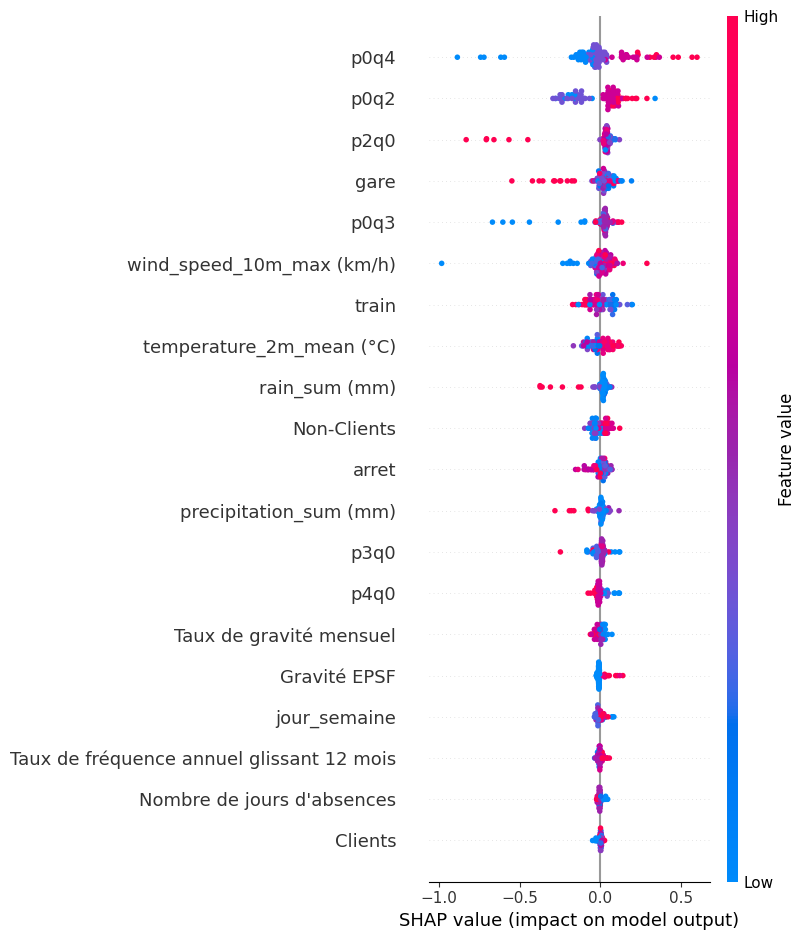

In [31]:

explainer_rf = shap.Explainer(model, sample_x)
shap_values_rf = explainer_rf(sample_x)
shap.summary_plot(shap_values_rf, sample_x)

En utilisant les shap values on peut voir une autre façon d'expliquer l'importance de nos features dans le cadre d'un modèle de Machine Learning. Ici on voit que les variables les plus importantes sont `p0q4` et `p0q2`. Cela signifie que le temps de retard de notre train cible aux gares précédentes (respectivement 4 et 2 gares avant la gare cible) est important afin de prédire le temps d'attente de notre train cible à la gare cible. On retrouve encore une fois la `gare` comme variable importante pour prédire le retard.

On voit que le jour de la semaine impacte peu notre retard, on pourrait alors se dire que ce qui compte réellement c'est l'heure de la journée plus que le jour de la semaine.

Aussi, si on compare par rapport à la feature importance réalisée plus tôt, on voit que selon la façon dont on calcule le score, les variables considérées importantes sont légèrement différentes. Mais globalement les variables déterminantes sont les mêmes (p0q4, gare, train, p0q2).

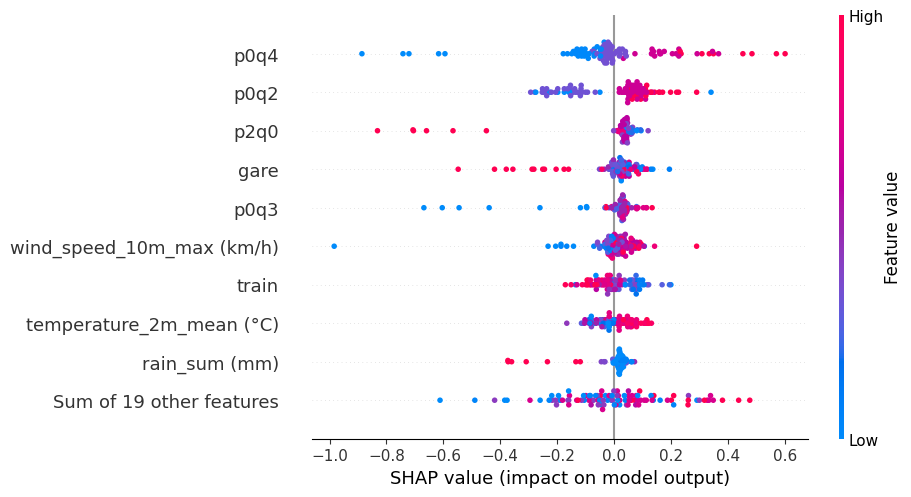

In [ ]:
# voici un zoom sur les variables les plus impactantes
shap.plots.beeswarm(shap_values_rf) 

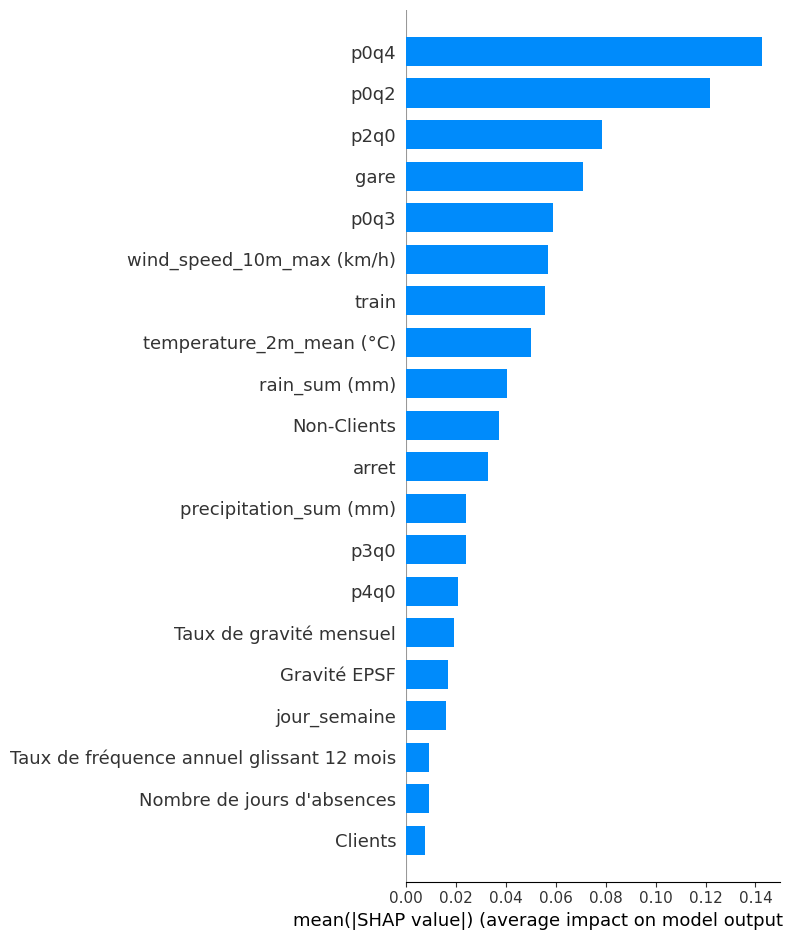

In [38]:

shap.summary_plot(shap_values_rf[:, :], x_train, plot_type="bar")


In [ ]:
style = """
<style>
    .lime, .lime * {
        background-color: #BBD;
        color: black;
    }
</style>
"""
HTML(style)


In [ ]:

# Initialiser l'expliqueur LIME pour les données tabulaires
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=x_train.values,
    feature_names=x_train.columns,
    class_names=['cible'],
    mode='regression'
)

# Choisissez une instance spécifique que vous souhaitez expliquer
i = 23  # index de l'instance dans X_train_imputed
exp = explainer.explain_instance(
    data_row=x_train.iloc[i].values, 
    predict_fn=rf_model.predict
)

# Afficher l'explication
exp.show_in_notebook(show_table=True, show_all=False)


### 8.2) Feature importance du Xgboost

In [41]:
xgb_r = XGBRegressor(n_jobs=-1, random_state = 15)

xgb_r.fit(x_train_split,y_train_split)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=15, ...)

<Axes: >

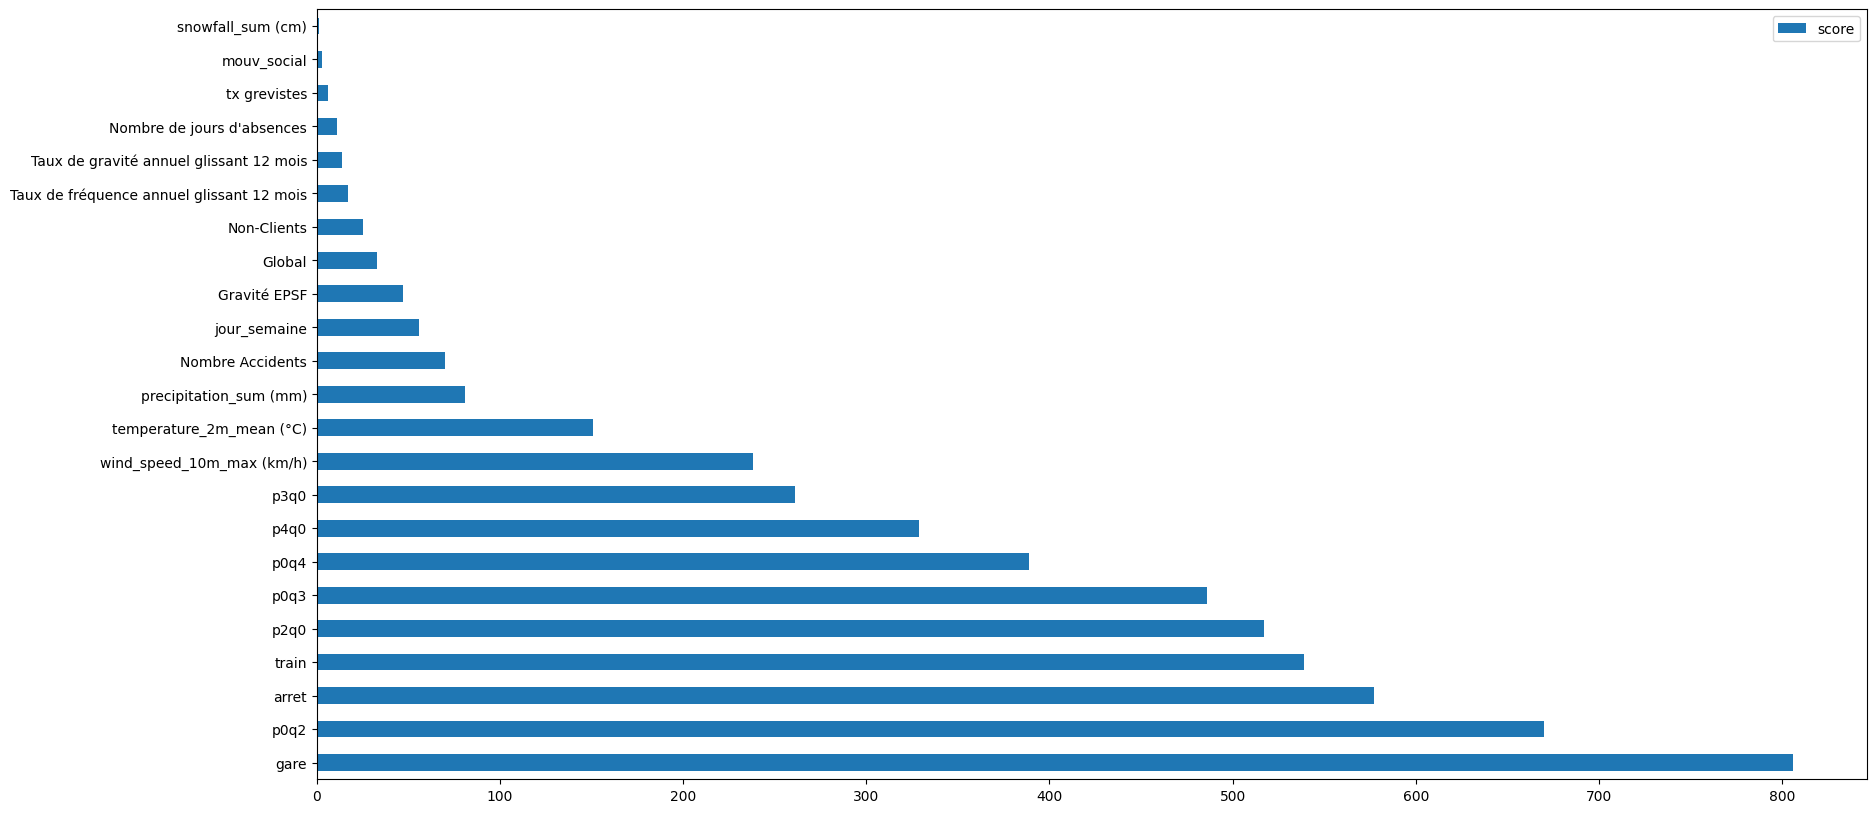

In [46]:
feature_important = xgb_r.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

On retrouve à nouveau les variables gare, p0q2 etc. qui sont également les variables considérées importantes pour le modèle random forest. Autrement dit, pour les deux modèles, l'ordre d'importance des features est similaire. 

**Interprétation avec shap values**

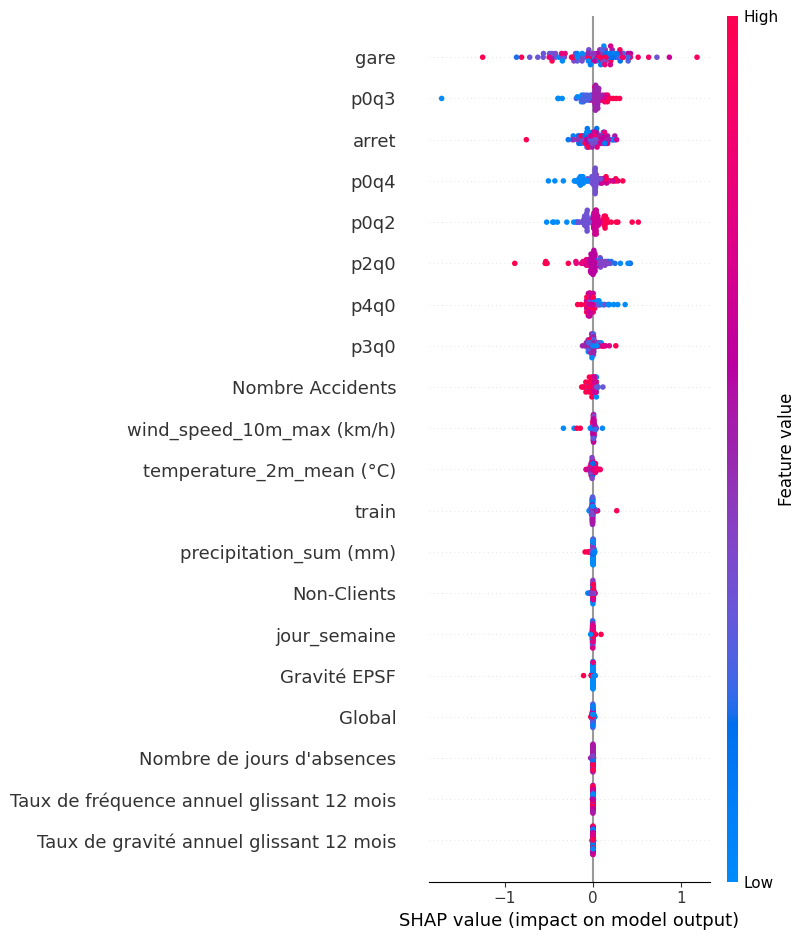

In [ ]:
explainer_rf = shap.Explainer(xgb_r, x_train_split.iloc[:100])
shap_values_rf = explainer_rf(x_train_split.iloc[:100])
shap.summary_plot(shap_values_rf, x_train_split.iloc[:100])

Si on utilise les shap values pour obtenir la feature importance, on obtient un ordre différent mais les variables significatives restent les mêmes. La gare est la variable la plus importante suivie de p0q3 et de l'arrêt. 

## 10) Comparaison des résultats

In [ ]:
comparaison_finale = pd.DataFrame(comparaison,columns=['Methode',"Modele","Weighted_Accuracy"])
print(tabulate(comparaison_finale, headers = "keys", tablefmt = "fancy_grid"))

╒════╤══════════════════╤════════════════════════╤═════════════════════╕
│    │ Methode          │ Modele                 │   Weighted_Accuracy │
╞════╪══════════════════╪════════════════════════╪═════════════════════╡
│  0 │ Methode_Standard │ benchmark rf           │            0.793473 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  1 │ Methode_Standard │ Kmeans                 │            0.958837 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  2 │ Methode_rf       │ RandomForestClassifier │            0.717271 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  3 │ Methode_         │ RandomForestRegressor  │            0.781494 │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  4 │ Methode_Mean     │ VotingClassifierSoft   │            0.86958  │
├────┼──────────────────┼────────────────────────┼─────────────────────┤
│  5 │ Methode_Mean     │ VotingClassifierHard   │ 

Finalement après avoir essayé beaucoup de méthodes (classification, régressions) beaucoup de modèles (xgboost, rf, régression logistique, ...) on voit dans le tableau une partie des meilleurs modèles. On voit que la plupart des meilleurs modèles sont les modèles d'arbres, qui ont pour force de prendre en compte des relations non linéaires. 

On va améliorer ces meilleurs modèles encore plus dans le notebook `model_testing.ipynb`